# HRV-Based Early Cardiac Risk Detection with CDED Dataset
This notebook covers data loading, preprocessing, HRV feature extraction from ECG files, merging clinical and HRV data, training multiple models, cross-validation, and hyperparameter tuning.

In [1]:

# Imports and basic setup
import pandas as pd
import numpy as np
import os
import glob
import wfdb
import neurokit2 as nk
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


## Step 1: Load Clinical CSV Data

In [2]:

base_path = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/DATA_discription/'

demographics_path = os.path.join(base_path, 'GE-79_Summary_Table-Demographics-MRI-Part1.csv')
labs_path = os.path.join(base_path, 'GE-79_Summary_Table-Labs-BP-Ophthalmogic-Walk.csv')
history_path = os.path.join(base_path, 'GE-79_Summary_Table-MRI-Part5-History.csv')

demographics = pd.read_csv(demographics_path, encoding='latin1')
labs_bp = pd.read_csv(labs_path, encoding='latin1')
history = pd.read_csv(history_path, encoding='latin1')

print("Demographics shape:", demographics.shape)
print("Labs shape:", labs_bp.shape)
print("History shape:", history.shape)


Demographics shape: (121, 254)
Labs shape: (121, 170)
History shape: (121, 174)


## Step 2: Preprocess clinical data and merge

In [4]:
print(history.columns.tolist())


['patient ID', 'visit', 'Perfusion Vascular (Lepto MCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 Right - 6 min', 'Perfusion Vascular (POCA) - baseline 1 Right - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 whole - 6 min', 'Perfusion Vascular (ACA Perf) -  baseline 1 whole - 6 min', 'Perfusion Vascular (ACHA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto ACA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto MCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 whole - 6 min', 'Perfusion Vascular (POCA) - baseline 1 whole - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACA Perf) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACHA) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (

In [5]:

# Remove trailing/leading spaces from all columns
labs_bp.columns = labs_bp.columns.str.strip()
history.columns = history.columns.str.strip()
demographics.columns = demographics.columns.str.strip()

# Rename columns consistently
labs_bp.rename(columns={'patient ID': 'patient_id', 'Visit': 'visit'}, inplace=True)
history.rename(columns={'patient ID': 'patient_id', 'visit': 'visit'}, inplace=True)
demographics.rename(columns={'patient_id': 'patient_id', 'visit': 'visit'}, inplace=True)  # change accordingly if different

# Now merge
df = pd.merge(demographics, labs_bp, on=['patient_id', 'visit'], how='inner')
df = pd.merge(df, history, on=['patient_id', 'visit'], how='left')


print("Merged dataset shape:", df.shape)
print(df[['patient_id', 'visit']].head())


Merged dataset shape: (121, 594)
  patient_id  visit
0      S0030      2
1      S0033      2
2      S0064      2
3      S0068      2
4      S0078      2


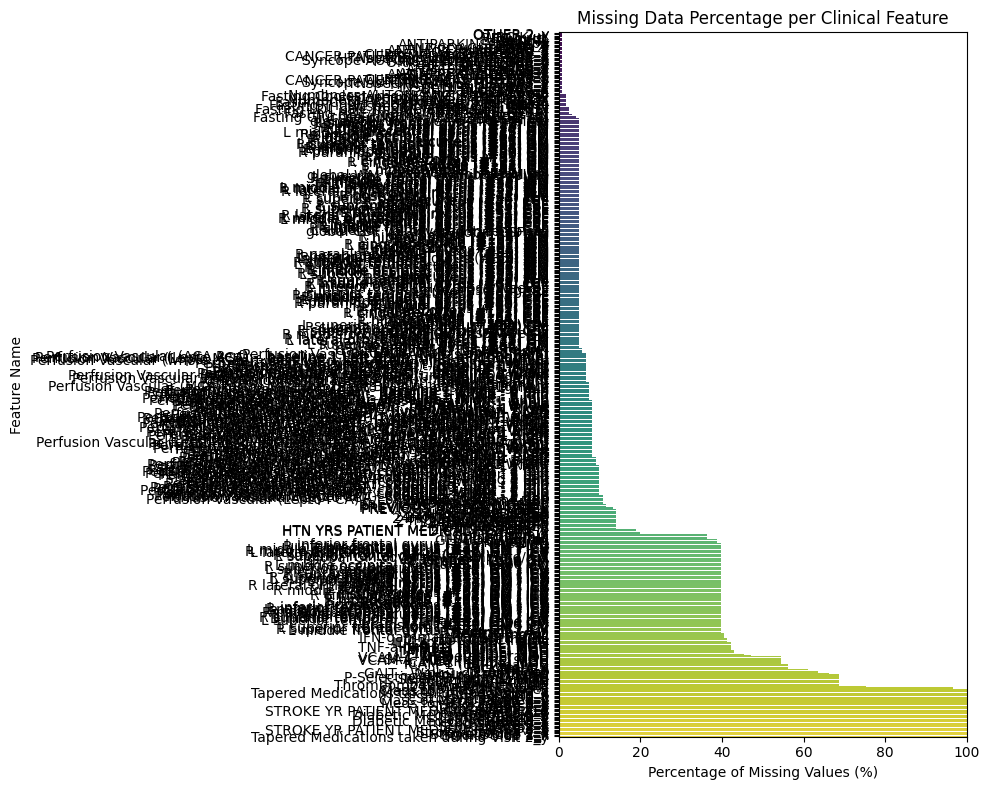

In [37]:
missing_counts = df.isna().sum()
missing_perc = (missing_counts / len(df)) * 100
missing_perc = missing_perc[missing_perc > 0].sort_values(ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x=missing_perc.values, y=missing_perc.index, palette="viridis")
plt.xlabel('Percentage of Missing Values (%)')
plt.ylabel('Feature Name')
plt.title('Missing Data Percentage per Clinical Feature')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


## Step 3: Define CAN risk label from clinical columns

In [6]:

print(df['DM, Non-DM, STROKE'].unique())
print(df['HTN or not'].unique())

autonomic_cols = [
    'Dizziness AUTONOMIC SYMPTOMS_x',
    'Syncope AUTONOMIC SYMPTOMS_x',
    'OH AUTONOMIC SYMPTOMS_x'
]
print(df[autonomic_cols].head())

def define_can_risk(row):
    has_diabetes = row['DM, Non-DM, STROKE'] == 'DM'
    has_htn = row['HTN or not'] == 'HTN'

    autonomic_cols = [
        'Dizziness AUTONOMIC SYMPTOMS_x',
        'Syncope AUTONOMIC SYMPTOMS_x',
        'OH AUTONOMIC SYMPTOMS_x'
    ]
    
    has_autonomic = any(
        str(row.get(col)).strip().upper() == 'YES'
        for col in autonomic_cols if col in row and pd.notna(row[col])
    )

    if has_diabetes and (has_autonomic or has_htn):
        return 1
    else:
        return 0

df['CAN_risk_label'] = df.apply(define_can_risk, axis=1)

print(df['CAN_risk_label'].value_counts())


['Non-DM' 'DM']
['ntn' 'HTN' nan]
  Dizziness AUTONOMIC SYMPTOMS_x Syncope AUTONOMIC SYMPTOMS_x  \
0                             NO                           NO   
1                             NO                           NO   
2                             NO                           NO   
3                             NO                           NO   
4                             NO                           NO   

  OH AUTONOMIC SYMPTOMS_x  
0                      NO  
1                      NO  
2                      NO  
3                      NO  
4                      NO  
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


## Step 4: Extract HRV features from ECG records

In [7]:

ecg_folder = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/Data/ECG/'

hrv_list = []

for record_path in glob.glob(os.path.join(ecg_folder, '*ECG.hea')):
    record_name = os.path.splitext(os.path.basename(record_path))[0].replace('.hea','')
    try:
        record = wfdb.rdrecord(os.path.join(ecg_folder, record_name))
        ecg_signal = record.p_signal[:, 0]  # first channel
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=record.fs)
        hrv = nk.hrv_time(signals["ECG_R_Peaks"], sampling_rate=record.fs)
        hrv['patient_id'] = record_name[:5]  # adjust if needed
        hrv['visit'] = 2  # set visit (adjust if known)
        hrv_list.append(hrv)
    except Exception as e:
        print(f"Failed {record_name}: {e}")

df_hrv = pd.concat(hrv_list, ignore_index=True)
print(df_hrv.head())


   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  879.029586   76.276373   76.742899   26.111553   69.216742   39.507039   
1  982.590571  123.302236   84.304607   89.460749   64.294791   88.414396   
2  685.945355   53.959304   59.012233   19.816811   49.785432   32.498280   
3  758.582359  228.805327  196.530270   94.513943  139.704868  130.124056   
4  759.156627  293.123764   96.469767  264.880697  101.417513  265.055038   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_Prc20NN  \
0         NaN         NaN   20.713638   20.728922  ...        821.0   
1         NaN         NaN   65.333454   65.414853  ...        956.0   
2         NaN         NaN   14.399222   14.406518  ...        651.0   
3         NaN         NaN  133.358894  133.361227  ...        631.0   
4         NaN         NaN  391.413609  391.807815  ...        583.8   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN    HRV_HTI  \
0        961.0   1.479290  17.307692 

## Step 5: Merge clinical data with HRV features (Left join) and Impute missing HRV

In [8]:

df_full = pd.merge(df, df_hrv, on=['patient_id', 'visit'], how='left')

print("Merged dataset shape:", df_full.shape)

missing_hrv_count = df_full['HRV_MeanNN'].isna().sum()
print(f"Missing HRV feature rows: {missing_hrv_count} out of {df_full.shape[0]}")

df_full['hrv_available'] = df_full['HRV_MeanNN'].notna().astype(int)

hrv_columns = df_hrv.columns.drop(['patient_id', 'visit'])

for col in hrv_columns:
    median_val = df_full[col].median()
    df_full[col].fillna(median_val, inplace=True)

print("After imputation, missing values per column:")
print(df_full[hrv_columns].isna().sum())


Merged dataset shape: (121, 620)
Missing HRV feature rows: 79 out of 121
After imputation, missing values per column:
HRV_MeanNN      0
HRV_SDNN        0
HRV_SDANN1      0
HRV_SDNNI1      0
HRV_SDANN2      0
HRV_SDNNI2      0
HRV_SDANN5      0
HRV_SDNNI5      0
HRV_RMSSD       0
HRV_SDSD        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_SDRMSSD     0
HRV_Prc20NN     0
HRV_Prc80NN     0
HRV_pNN50       0
HRV_pNN20       0
HRV_MinNN       0
HRV_MaxNN       0
HRV_HTI         0
HRV_TINN        0
dtype: int64


## Step 6: Prepare features and target for modeling

In [9]:

features_to_drop = ['patient_id', 'visit', 'DM, Non-DM, STROKE', 'HTN or not', 
                    'Dizziness AUTONOMIC SYMPTOMS_x', 'Syncope AUTONOMIC SYMPTOMS_x', 
                    'OH AUTONOMIC SYMPTOMS_x', 'CAN_risk_label']

X = df_full.drop(columns=features_to_drop).select_dtypes(include=[np.number])
y = df_full['CAN_risk_label']

print(f"Feature shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Feature shape: (121, 531)
Target distribution:
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


In [61]:
print("Total data points in the final dataset:", df_full.shape[0])


Total data points in the final dataset: 121


## Step 7: Scale features and cross-validate multiple models

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"Running CV for {name}...")
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"{name} CV accuracy scores: {scores}")
    print(f"{name} Mean accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})\n")


Running CV for Random Forest...
Random Forest CV accuracy scores: [0.92       0.79166667 0.875      0.91666667 0.79166667]
Random Forest Mean accuracy: 0.8590 (+/- 0.0572)

Running CV for Logistic Regression...
Logistic Regression CV accuracy scores: [0.84       0.75       0.83333333 0.75       0.70833333]
Logistic Regression Mean accuracy: 0.7763 (+/- 0.0516)

Running CV for XGBoost...
XGBoost CV accuracy scores: [0.88       0.875      0.875      1.         0.95833333]
XGBoost Mean accuracy: 0.9177 (+/- 0.0519)

Running CV for KNN...
KNN CV accuracy scores: [0.6        0.58333333 0.54166667 0.54166667 0.66666667]
KNN Mean accuracy: 0.5867 (+/- 0.0461)

Running CV for SVM...
SVM CV accuracy scores: [0.8        0.75       0.58333333 0.625      0.75      ]
SVM Mean accuracy: 0.7017 (+/- 0.0827)



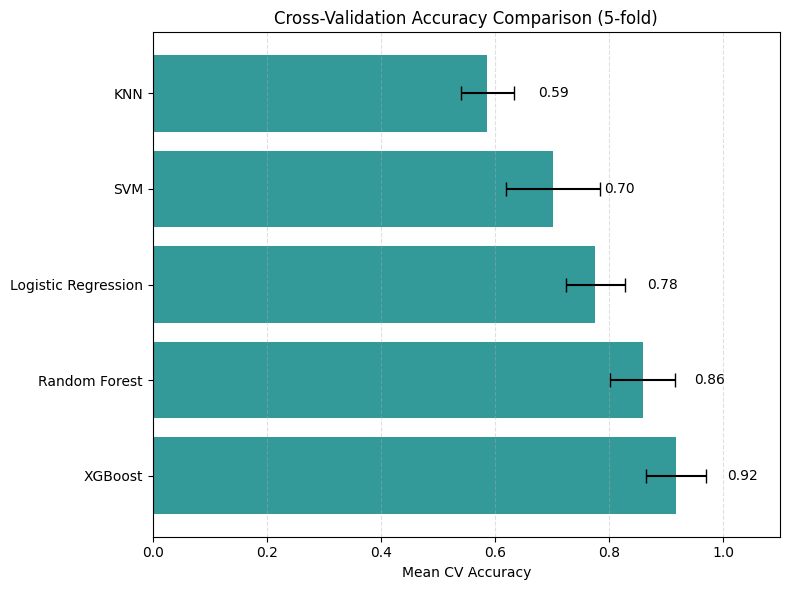

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results dictionary is ready
cv_means = {model: np.mean(scores) for model, scores in results.items()}
cv_stds = {model: np.std(scores) for model, scores in results.items()}

# Sort models
sorted_models = sorted(cv_means, key=cv_means.get, reverse=True)
mean_values = [cv_means[model] for model in sorted_models]
std_values = [cv_stds[model] for model in sorted_models]

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(sorted_models, mean_values, xerr=std_values, color='teal', alpha=0.8, capsize=5)

# Add value labels slightly to the right of the bars
for bar, mean in zip(bars, mean_values):
    plt.text(mean + 0.09, bar.get_y() + bar.get_height()/2, f'{mean:.2f}', va='center')

plt.xlabel('Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Comparison (5-fold)')
plt.xlim(0, 1.1)  # Extend x-axis to leave room for labels
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Step 8: Hyperparameter tuning for XGBoost

In [16]:

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2],
    'gamma': [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Best CV accuracy: 0.9337


## Step 9: Final evaluation with tuned model

In [17]:

best_model = grid_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[17  3]
 [ 2 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.83      0.88      0.86        17

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



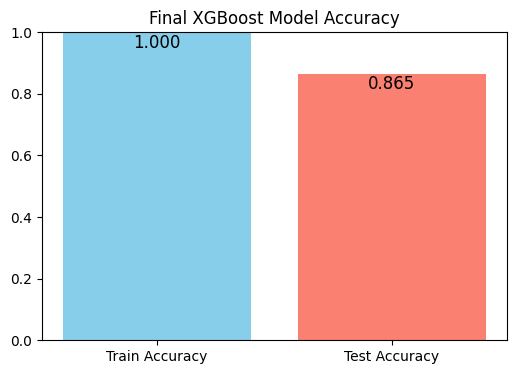

In [63]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

plt.figure(figsize=(6,4))
bars = plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0,1)
plt.title('Final XGBoost Model Accuracy')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.3f}', ha='center', color='black', fontsize=12)
plt.show()


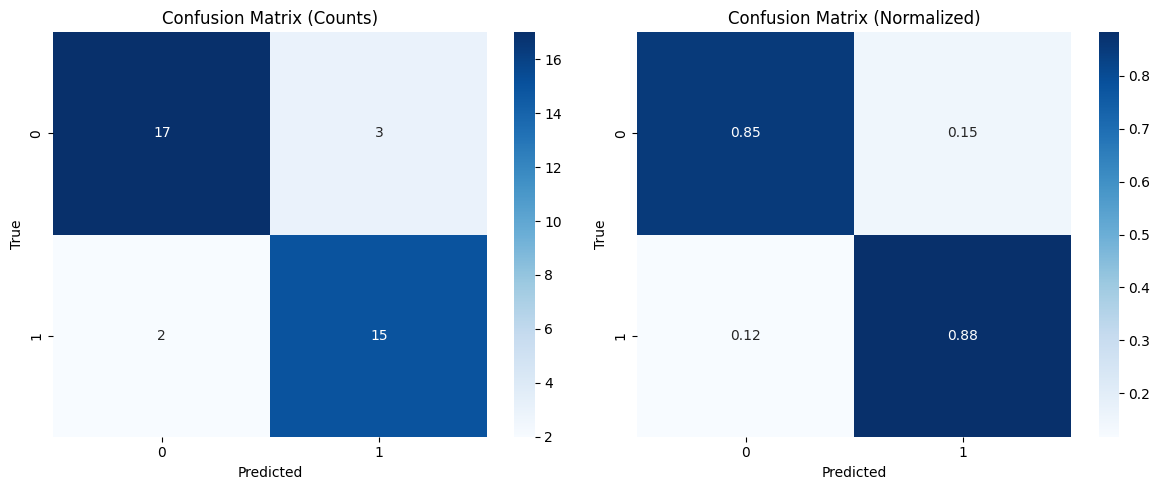

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()


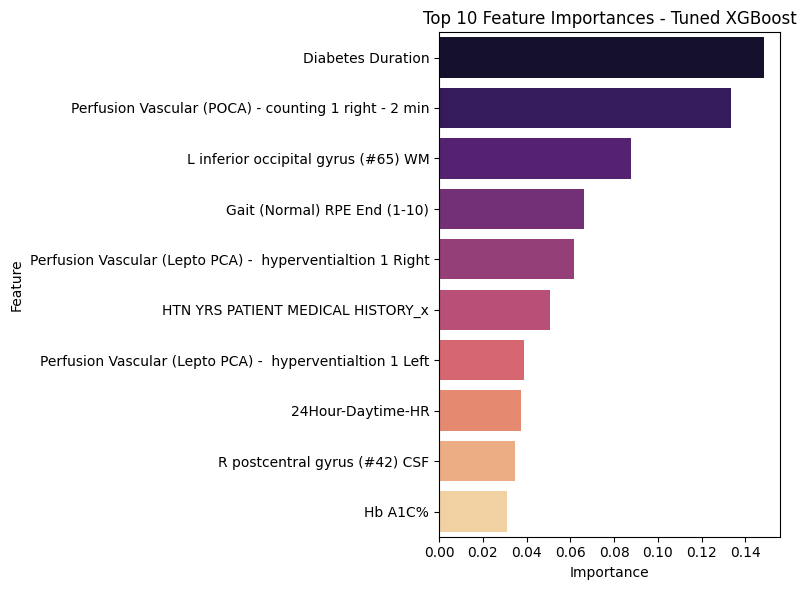

In [23]:
# Extract feature importance from the best XGBoost model
importances = best_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='magma')
plt.title('Top 10 Feature Importances - Tuned XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


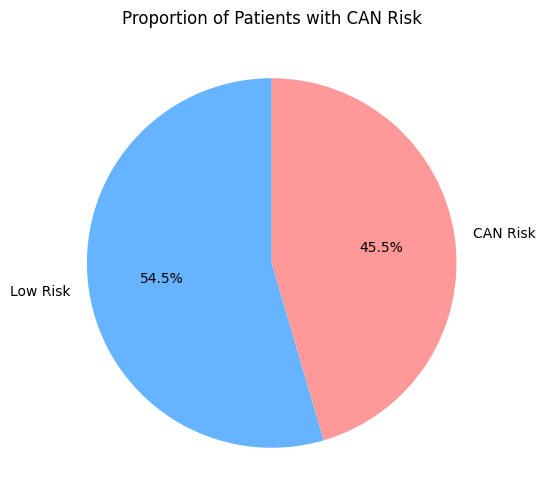

In [46]:
# Pie chart for CAN Risk
risk_counts = df_full['CAN_risk_label'].value_counts().reindex([0,1], fill_value=0)

plt.figure(figsize=(6,6))
plt.pie(risk_counts, labels=["Low Risk", "CAN Risk"], autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"], startangle=90)
plt.title("Proportion of Patients with CAN Risk")
plt.show()


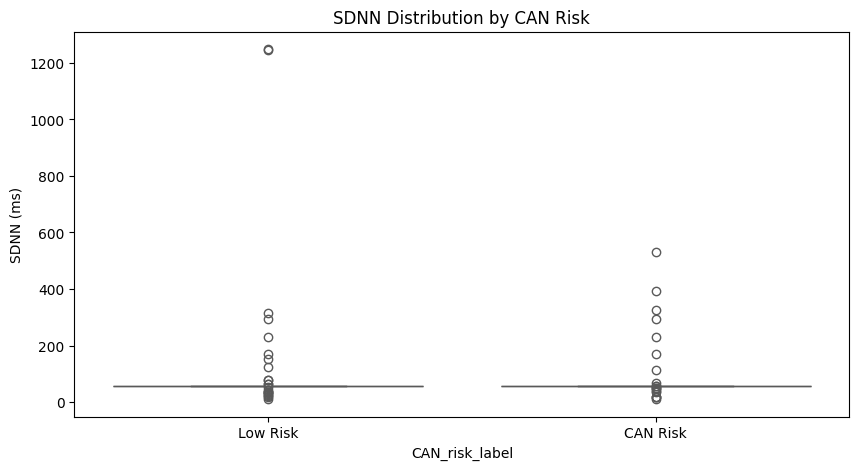

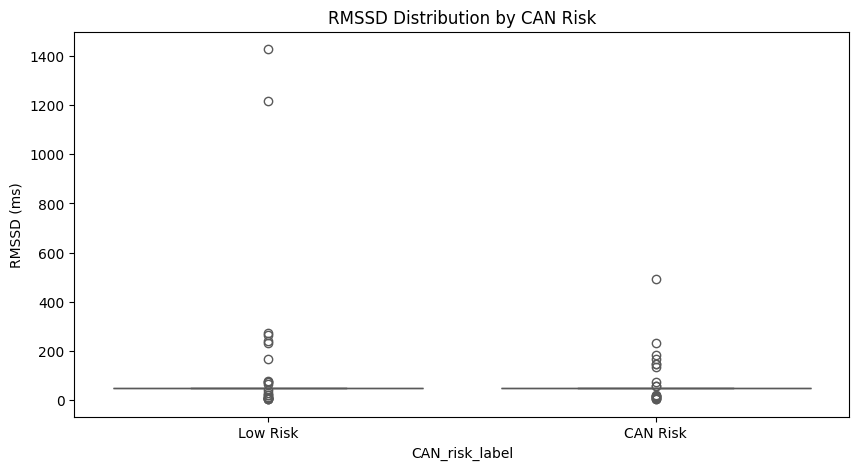

In [47]:
plt.figure(figsize=(10,5))
sns.boxplot(x='CAN_risk_label', y='HRV_SDNN', data=df_full, palette="Set2")
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("SDNN Distribution by CAN Risk")
plt.ylabel("SDNN (ms)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='CAN_risk_label', y='HRV_RMSSD', data=df_full, palette="Set2")
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("RMSSD Distribution by CAN Risk")
plt.ylabel("RMSSD (ms)")
plt.show()


In [50]:
df_plot = df_full.copy()
df_plot['CAN Risk'] = df_plot['CAN_risk_label'].map({0: 'Low Risk', 1: 'CAN Risk'})

# Select columns to plot - choose only columns that exist
cols_to_plot = ['HRV_SDNN', 'HRV_RMSSD']

# Add LF/HF ratio if exists
if 'HRV_LF_HF_ratio' in df_plot.columns:
    cols_to_plot.append('HRV_LF_HF_ratio')

cols_to_plot.append('CAN Risk')  # target for hue

print("Plotting HRV features:", cols_to_plot)


Plotting HRV features: ['HRV_SDNN', 'HRV_RMSSD', 'CAN Risk']


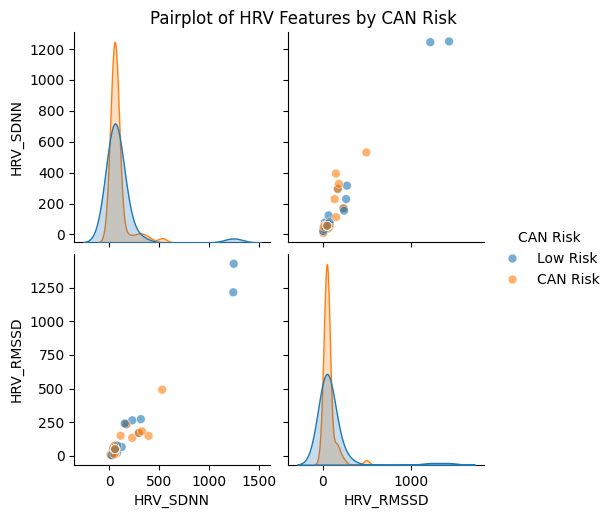

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_plot[cols_to_plot], hue='CAN Risk', diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Pairplot of HRV Features by CAN Risk", y=1.02)
plt.show()


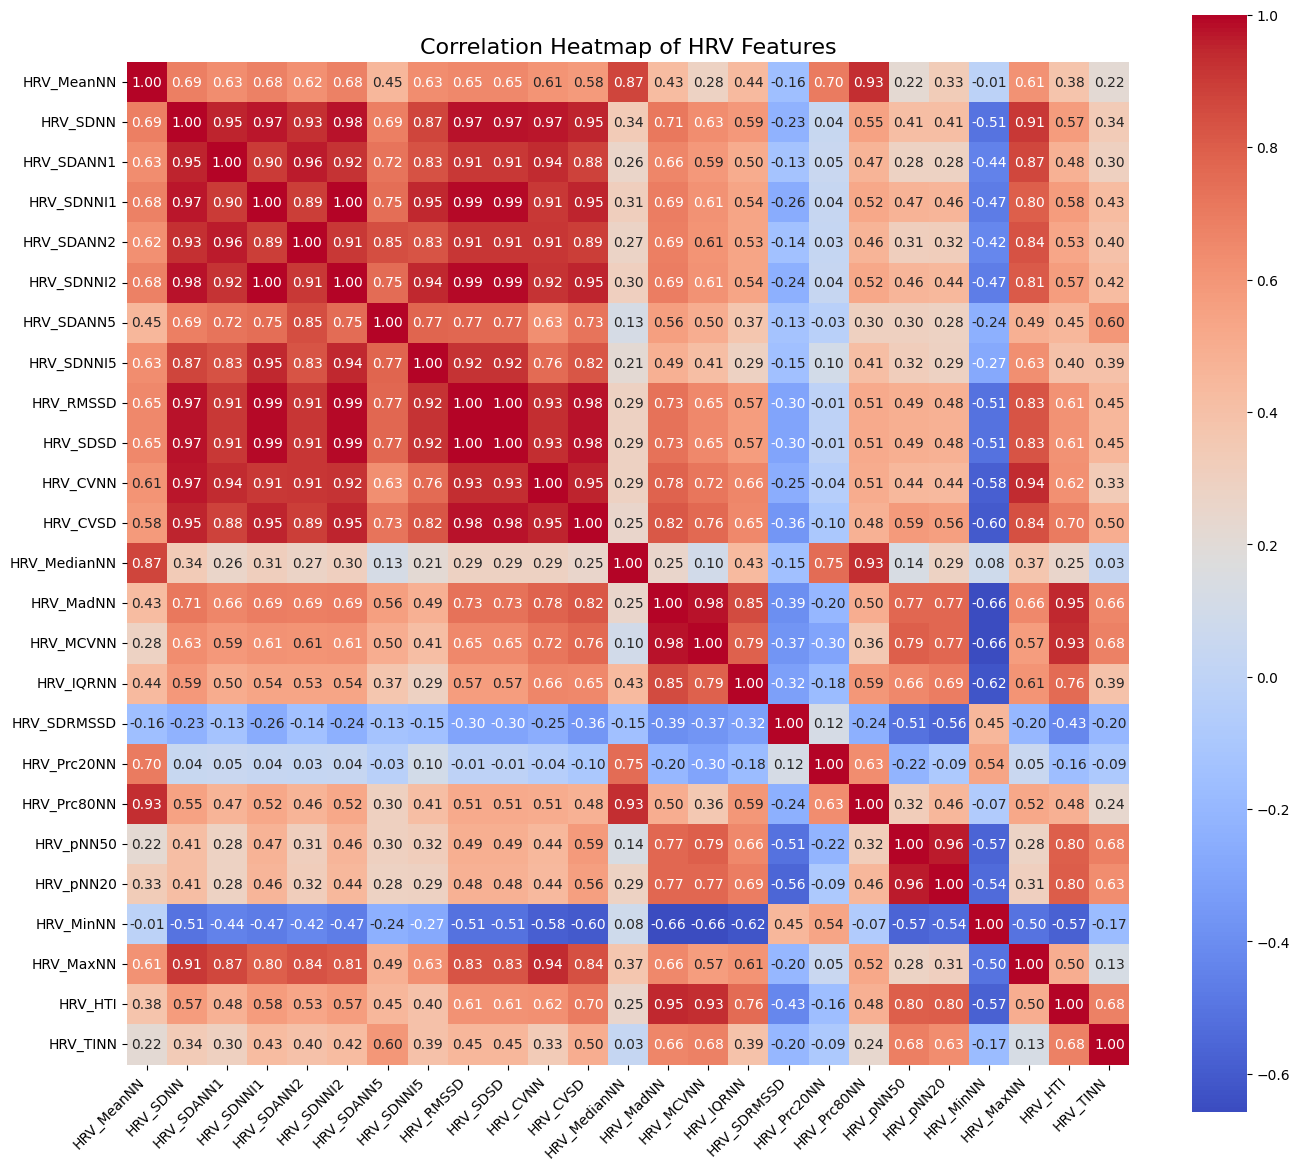

In [60]:
plt.figure(figsize=(14,12))
sns.heatmap(df_full[hrv_cols_existing].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of HRV Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


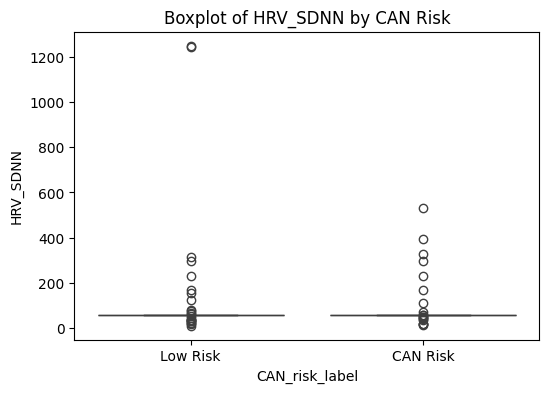

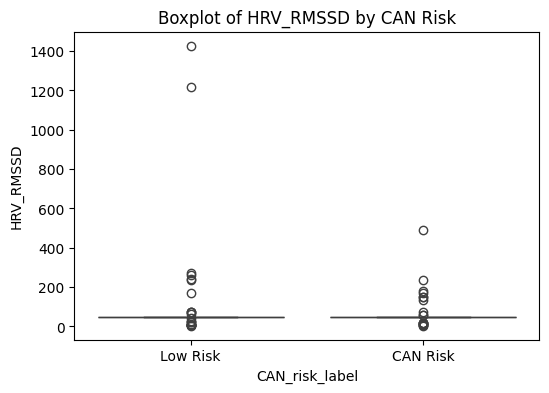

In [53]:
key_hrv_feats = ['HRV_SDNN', 'HRV_RMSSD']
for feat in key_hrv_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='CAN_risk_label', y=feat, data=df_full)
    plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
    plt.title(f"Boxplot of {feat} by CAN Risk")
    plt.show()


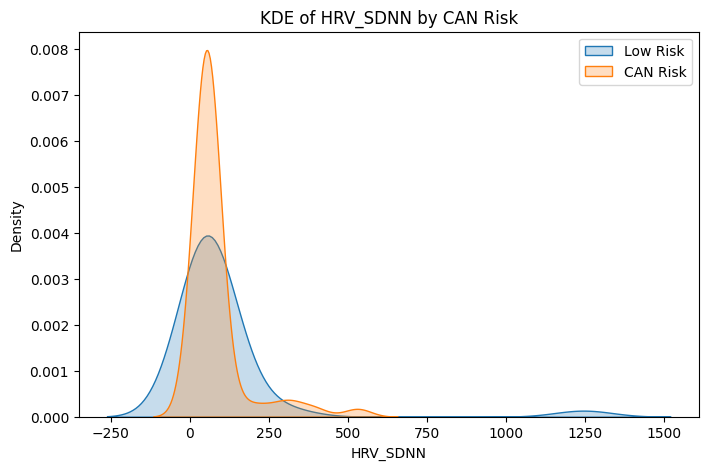

In [54]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==0, 'HRV_SDNN'], label='Low Risk', shade=True)
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==1, 'HRV_SDNN'], label='CAN Risk', shade=True)
plt.title("KDE of HRV_SDNN by CAN Risk")
plt.xlabel('HRV_SDNN')
plt.legend()
plt.show()


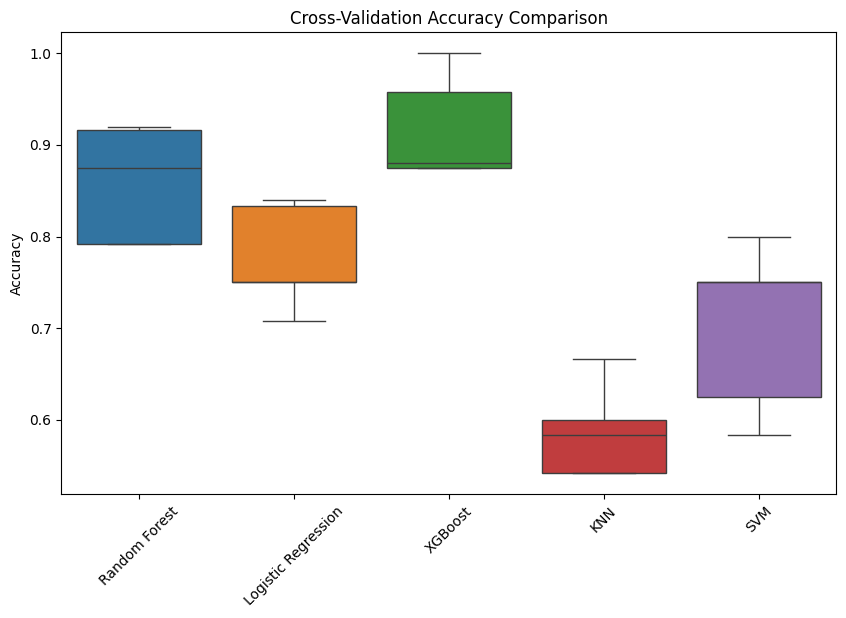

In [55]:
cv_results_df = pd.DataFrame({k: v for k, v in results.items()})
plt.figure(figsize=(10,6))
sns.boxplot(data=cv_results_df)
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


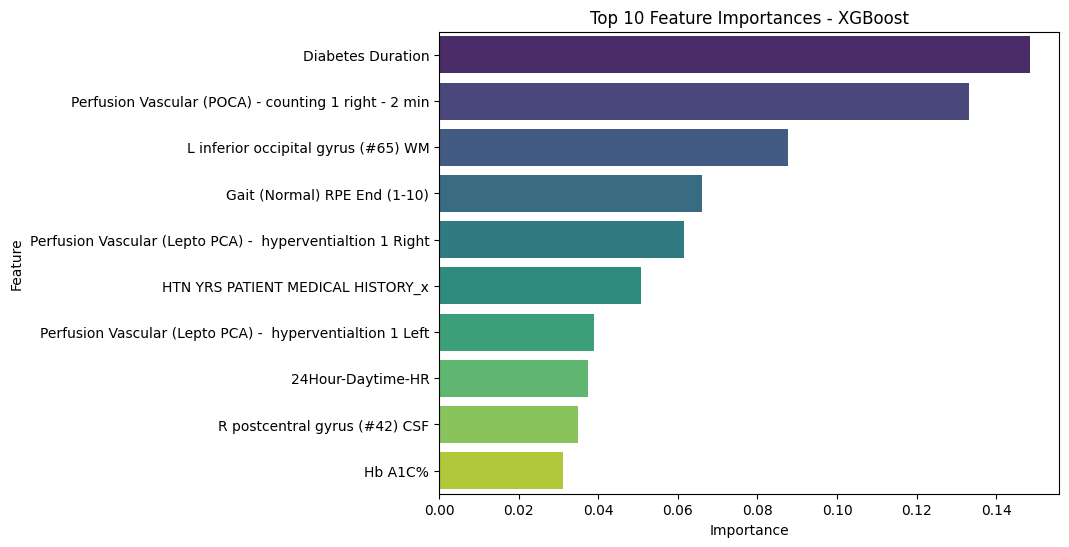

In [57]:
importances = best_model.feature_importances_
feat_names = X.columns

feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
